# Slide Graph Maker
This is for making graphs for the slides to be sent to the head of school

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import re
import pathlib as Path
import html5lib
import json
import matplotlib.ticker as mtick
import plotly.express as px

In [2]:
#This finds files that were saved by the Module Scraper Code
def file_finder(school=None, level=None, givenList=None, filename=None, module=None):
    #Set the path to the overall directory with our input files
    dir_raw=Path.Path("ModuleInformation")
    
    #This locates the subdirectory where files by school, level or list can be found
    subdirectory=""
    #Set the subdirectory 
    if level != None:
        subdirectory+= "Level=%d" %(level)
    if school != None:
        subdirectory+= "_School="+school.replace(" ", "-")
    if filename != None:
        subdirectory = filename
    if module != None:
        subdirectory = ("IndividualModules/%s" %module)
        
    #If a subdirectory has indeed been set, change the path to reflect this
    if len(subdirectory) > 0:
        dir_raw =dir_raw / subdirectory
        

    #Read the files for the assessment and descriptors in, closing the file immediately after
    with open(dir_raw / "assessments.json", 'r') as infile:
        print("Reading from %s" % dir_raw)
        if module != None:
            assessments=pd.read_json(infile, orient="columns")
        else:
            assessments=pd.read_json(infile)
    with open(dir_raw / "descriptors.json", 'r') as infile:
        print("Reading from %s" % dir_raw)
        if module != None:
            descriptors=pd.read_json(infile, typ="series")
        else:
            descriptors=pd.read_json(infile)
    
    assessments["Level"]=assessments["Level"].apply(lambda x: pd.to_numeric(x.split('(')[0], errors='ignore'))
    #This is the dataset cleaning, so that they are ready for presentation
    assessments["% of Final Grade"]=pd.to_numeric(assessments["% of Final Grade"], errors='coerce')
    assessments=assessments.replace("Multiple Choice Questionnaire (Short)", "Multiple Choice Questionnaire")
    assessments["Assessment Type"]=assessments["Assessment Type"].astype("category")
    #assessments["Stage"]=assessments["Stage"].replace("M", 4)
    assessments["Student Credits"]=((assessments["Scaled % of Final Grade"]/100)*5)*assessments["Enrolled Students 22/23"]
    assessments["Assessment Credits"]=((assessments["Scaled % of Final Grade"]/100)*5)
    #Return the desired assessment and description information
    return assessments, descriptors

In [3]:
#Test the file finder function 
assessments, descriptors = file_finder()

assessments

Reading from ModuleInformation
Reading from ModuleInformation


,Description,Timing,Open Book Exam,Component Scale,Must Pass Component,% of Final Grade,Assessment Type,Module Code,Scaled % of Final Grade,Work Type,Level,Credits,School,Module Coordinator,Semester,Enrolled Students 22/23,Stage,Student Credits,Assessment Credits
0,Fieldwork: Fieldwork on campus related to camp...,Throughout the Trimester,None,Graded,No,30,Fieldwork,DSCY10060,30,In person,1,5.0,Electrical & Electronic Eng,Professor Andrew Keane,Spring,37,NaN,55.5,1.50
1,Presentation: In class presentation of group p...,Week 12,None,Graded,No,30,Presentation,DSCY10060,30,In person,1,5.0,Electrical & Electronic Eng,Professor Andrew Keane,Spring,37,NaN,55.5,1.50
2,Multiple Choice Questionnaire: Online Multiple...,Throughout the Trimester,None,Standard conversion grade scale 40%,No,40,Multiple Choice Questionnaire,DSCY10060,40,Blended,1,5.0,Electrical & Electronic Eng,Professor Andrew Keane,Spring,37,NaN,74.0,2.00
3,Examination: 2 HOUR Examination,2 hour End of Trimester Exam,No,Alternative linear conversion grade scale 40%,No,65,Examination,EEEN10010,65,In person,1,5.0,Electrical & Electronic Eng,Assoc Professor Simon Kelly,Autumn,298,NaN,968.5,3.25
4,"Lab Report: Two in-person labs will be run , w...",Varies over the Trimester,None,Alternative linear conversion grade scale 40%,No,10,Lab Report,EEEN10010,10,Blended,1,5.0,Electrical & Electronic Eng,Assoc Professor Simon Kelly,Autumn,298,NaN,149.0,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1270,Assignment: Final report and presentation,Throughout the Trimester,None,Pass/Fail Grade Scale,Yes,70,Assignment,MEEN50080,280,At home,5,20.0,Mechanical & Materials Eng,Dr David McKeown,Autumn&Spring&Summer(separate),0,NaN,0.0,14.00
1271,Assignment: Industrial Partner Assessment form,Throughout the Trimester,None,Pass/Fail Grade Scale,No,10,Assignment,MEEN50080,40,At home,5,20.0,Mechanical & Materials Eng,Dr David McKeown,Autumn&Spring&Summer(separate),0,NaN,0.0,2.00
1272,Assignment: Development of work plan,Throughout the Trimester,None,Pass/Fail Grade Scale,Yes,20,Assignment,MEEN50090,120,At home,5,30.0,Mechanical & Materials Eng,Dr David McKeown,Autumn&Spring&Summer(separate),0,NaN,0.0,6.00
1273,Assignment: Industrial Partner Assessment form,Throughout the Trimester,None,Pass/Fail Grade Scale,No,10,Assignment,MEEN50090,60,At home,5,30.0,Mechanical & Materials Eng,Dr David McKeown,Autumn&Spring&Summer(separate),0,NaN,0.0,3.00


In [4]:
susceptibility={"Assignment" :"susceptible", \
                "Attendance": "not susceptible", \
                "Class Test" : "not susceptible", \
                "Continuous Assessment": "susceptible", \
               "Essay": "susceptible", \
                "Examination": "not susceptible", \
                "Fieldwork": "not susceptible", \
                "Group Project": "susceptible", \
                "Journal": "not susceptible",\
               "Lab Report": "not susceptible", \
                "Multiple Choice Questionnaire": "not susceptible", \
                "Oral Examination": "not susceptible", \
               "Portfolio" : "susceptible",  \
                "Practical Examination": "not susceptible", \
                "Presentation" : "not susceptible", \
                "Project": "susceptible", \
               "Seminar": "not susceptible", \
               "Studio Examination" : "not susceptible",\
               "Assessments worth <2%": "not susceptible"}

In [5]:
work_type={"Assignment" :"At home", \
                "Attendance": "In person", \
                "Class Test" : "In person", \
                "Continuous Assessment": "At home", \
               "Essay": "At home", \
                "Examination": "In person", \
                "Fieldwork": "In person", \
                "Group Project": "Blended", \
                "Journal": "Blended",\
               "Lab Report": "Blended", \
                "Multiple Choice Questionnaire": "Blended", \
                "Oral Examination": "In person", \
               "Portfolio" : "Blended",  \
                "Practical Examination": "In person", \
                "Presentation" : "In person", \
                "Project": "At home", \
               "Seminar": "In person", \
               "Studio Examination" : "In person",\
               "Assessments worth <2%": "Unknown"}

In [6]:
#Builds a graph to indicate the susceptibility of a module set's assessments to Chat GPT
def workType_builder(assessments, scaled=True, school=None, level=None, givenList=None, filename=None, \
                     module=None, time=False, student_credits=False, with_internships=True, foldername=None):
    
    num_unique=len(assessments["Module Code"].unique())
    #Data Cleaning and Manipulation Part
    #########################################################################################
    #First we will reduce the assessments dataframe to just the columns we require here.
    if with_internships != True:
        Datasets=Path.Path("Datasets")
        internship_file= Datasets / "UCD_EngArch_InternshipModules.xlsx"
        internships=pd.read_excel(internship_file)

        new_assessments=assessments[~assessments["Module Code"].isin(internships["Code"])]
    else:
        new_assessments=assessments
    
    #For the pie chart, group by susceptibilty
    assessment_sus=new_assessments.groupby(by="Work Type").sum()
    #For the bar chart, group by assessment type
    assessment_total=new_assessments.groupby(by="Assessment Type").sum()

    #Choose whether or not you want to scale by credits, or take all modules to be equal, regardless of credits
    if student_credits==True:
        assessment_scale="Student Credits"
    elif scaled==True:
        assessment_scale="Scaled % of Final Grade"
    else:
        assessment_scale="% of Final Grade"
        
        
    total=assessment_sus[assessment_scale].sum()

    #Get the percentage each assessment type makes up of the overall for both graphs
    assessment_sus["% of Assessment"]=assessment_sus[assessment_scale].apply(lambda x: x/total)
    assessment_total["% of Assessment"]=assessment_total[assessment_scale].apply(lambda x: x/total)

    #The groupby function removed the categorical "Susceptibility" column. Bring it back
    assessment_total["Work Type"]=assessment_total.index.map(lambda x: work_type[x])

    #Sort the totals into descending order, to make it easier to see
    sorted_totals=assessment_total.sort_values(by="% of Assessment", ascending=False)
    #The groupby function removed the categorical "Susceptibility" column. Bring it back
    sorted_totals["Work Type"]=sorted_totals.index.map(lambda x: work_type[x])

    #Graph building part
    #############################################################################################################
    #Set the font
    plt.rcParams["font.family"] = "sans"
    
    #Make the figure
    fig, (ax, bx)=plt.subplots(ncols=2, figsize=(16, 9))

    #Make a pie chart on the desired axes
    if time == False:
        fig, ax=workType_pie(assessment_sus, fig, ax, num_unique)
    else:
        stage=False
        if filename != None:
            stage=True
        #Make the area level stacked chart
        fig, ax=workType_stackedBar(new_assessments, fig, ax, stage=stage, student_credits=student_credits)
        
    #Make the horizontal bar chart on the desired axes
    fig, bx=workType_barh(sorted_totals, fig, bx)
    
    #Here we want to set the overall title of the charts - to indicate what module subset they are describing
    what="College of Engineering and Architecture"
    if school != None:
        what=""
        what+="School of "
        what+=school
    if level != None:
        what+= " At Level %d" %level
    if filename != None:
        what="".join([(" "+i if i.isupper() else i) for i in filename])
    if module != None:
        what = module + " Module"
    if not with_internships:
        what = what + " Excluding Internships"

        
    #Set the overall title for the two graphs
    fig.suptitle("Assessment Breakdown in the %s" %what, fontsize=24)
    fig.tight_layout()
    
    if not time: 
        what = what + " Snapshot"
    
    
    #Describe what the figure is
    what=what.replace(" ", "-")
    
    if foldername== None:
        #Set the path to save the graphs
        dir_output=Path.Path("Graphs")
    
        #Set the filename for th figure
        dir_output=dir_output / "WorkType"
        dir_output.mkdir(parents=True, exist_ok=True)
    else:
        dir_output=foldername
        dir_output.mkdir(parents=True, exist_ok=True)
    
    filename= dir_output / ("%s.jpeg" %what)
    plt.savefig(filename, dpi="figure")

In [7]:
def workType_pie(assessment_sus, fig, ax, num_unique=None):
        #These are for selecting colours and hatching for each pie segment
    colour_dict={"At home": "#1f78b4", "Blended": "#a6cee3", "In person":"#b2df8a"}
    hatching_dict={"At home": None, "Blended": None, "In person":None}
    colours=[]
    hatching=[]
    #Get the colours and hatching for each pie segment
    for segment in assessment_sus.index:
        colours.append(colour_dict[segment])
        hatching.append(hatching_dict[segment])

    #Make the susceptibility pie chart
    ax.pie(assessment_sus["% of Assessment"],\
           wedgeprops = { 'linewidth' : 1.5, 'edgecolor' : 'white', "alpha" : 0.9}, \
           autopct="%1.1f%%", labels=assessment_sus.index, hatch=hatching ,\
           colors=colours, textprops={'fontsize':18})

    #Set the title of the pie chart for ease of understanding
    ax.set_title("Proportions of Different Assessment Kinds", fontsize=20)
    
    if num_unique!=None:
        ax.set_xlabel("\n\nNumber of Modules in this Breakdown: %d" %(num_unique), fontsize=20)
    
    return fig, ax

In [8]:
def workType_barh(sorted_totals, fig, bx):
    #These are for selecting colours and hatching for each bar in the bar chart
    colour_dict={"At home": "#1f78b4", "Blended": "#a6cee3", "In person":"#b2df8a"}
    hatching_dict={"At home": None, "Blended": None, "In person":None}
    colours=[]
    hatching=[]
    #Get the colours and hatching type based on susceptibilty
    for sus in sorted_totals["Work Type"]:
        colours.append(colour_dict[sus])
        hatching.append(hatching_dict[sus])
        
        
    #Make the assessment type breakdown bar chart, with colour and hatching indicating the susceptibility
    bx.barh(sorted_totals.index, sorted_totals["% of Assessment"].apply(lambda x:x*100), edgecolor="white", hatch = hatching ,\
           color=colours, alpha=0.9)
    
    #colors = {'fruit':'red', 'veggie':'green'}         
    #Set the options for the axes
    bx.tick_params(axis='y', labelsize=16)
    bx.tick_params(axis='x', labelsize=14)
    
    fmt = '%d%%' # Format you want the ticks, e.g. '40%'
    xticks = mtick.FormatStrFormatter(fmt)
    bx.xaxis.set_major_formatter(xticks)
    #ax.legend(fontsize=20)
    bx.set_xlabel("Percentage of Assessment",fontsize=18)
    #Set the title for the bar chart for ease of understanding
    bx.set_title("Assessment Type Breakdown", fontsize=20)
    
    #Do the legend
    labels = list(colour_dict.keys())
    handles = [plt.Rectangle((0,0),1,1, color=colour_dict[label]) for label in labels]
    bx.legend(handles, labels,fontsize=20)
    
    return fig, bx

In [9]:
def workType_stackedBar(assessments, fig, ax, stage=False, student_credits=False):
    #Choose whether or not you want to scale by credits, or take all modules to be equal, regardless of credits
    if student_credits==True:
        assessment_scale="Student Credits"
    else:
        assessment_scale="Assessment Credits"
        
    if stage==False:
        time="Level"
    else:
        time="Stage"
        
    #assessments[time] = assessment[time].map()
    #assessments[time]=assessments[time].astype("category")
    stackedbar=assessments.groupby(by=["Work Type", time], as_index=False).sum()
    
    #stackedbar=stackedbar.fillna(0)
    #print(stackedbar)
    
    #These are for selecting colours and hatching for each area segment
    colour_dict={"At home": "#1f78b4", "Blended": "#a6cee3", "In person":"#b2df8a"}
    hatching_dict={"At home": None, "Blended": None, "In person":None}
    colours=[]
    Stackedwork={}

    
    #Get the colours and hatching for each area segment
    for i, segment in enumerate(stackedbar["Work Type"].unique().tolist()):
        Stackedwork[segment]=stackedbar[stackedbar["Work Type"] == segment][assessment_scale].reset_index(drop=True)
        #print(Stackedwork[segment])
        #try:
        #    if (Stackedwork[segment].empty):
        #        Stackedwork[segment]=[0]*len(assessments[time].unique().tolist())
        #    else:
        #        Stackedwork[segment].fillna(0)
        #except:
        #    if Stackedwork[segment] == None:
        #        Stackedwork[segment]=[0]*len(assessments[time].unique().tolist())
        #    elif None in Stacked[segement]:
        #        index=Stacked[segement].index(None)
        #        Stacked[segement][index]=0
                                      
        #Make sure there is no difference between the x value and the y
        #diff=len(Stackedwork[segment])-len(assessments[time].unique().tolist())
        #for i in range(diff):
        #    print("Here")
        #    Stackedwork[segment][len(Stackedwork[segment])+1]=0.0
            
        if i ==0:
            Totalwork=Stackedwork[segment]
        else:
            Totalwork=Totalwork+Stackedwork[segment]
                                         
                                         
    #print(Totalwork)
    #If any work type are not included in the stacked bar, add in a value for that segment of 0
    for work in ["At home", "Blended", "In person"]: 
        if work not in Stackedwork.keys():
                Stackedwork[work]=np.zeros(len(assessments[time].unique().tolist()))

            
 
    ax.bar(["{}".format(level) for level in assessments[time].unique().tolist()],\
        (Stackedwork["At home"]), color=colour_dict["At home"])
        
    ax.bar(["{}".format(level) for level in assessments[time].unique().tolist()],\
           (Stackedwork["Blended"]), \
           bottom=(Stackedwork["At home"]), color=colour_dict["Blended"])
    
    ax.bar(["{}".format(level) for level in assessments[time].unique().tolist()],\
           (Stackedwork["In person"]), \
           bottom=(Stackedwork["Blended"])+(Stackedwork["At home"]), color=colour_dict["In person"])

    # Add percentages as labels to the stacked bars
    for idx in assessments[time].unique().tolist():
        start = 0
        for work in ["At home", "Blended", "In person"]:
            y=Stackedwork[work][idx-1]
            value = Stackedwork[work][idx-1]
            total = Totalwork[idx-1]
            if  y/max(Totalwork)> .05 :
                ax.text(
                x=idx-1,
                y=start + y / 2,
                s=f"{round(100 * value / total, 1)}%",
                fontsize=16,
                ha="center"
                )
            start += y
            
    #Set the options for the axes
    ax.tick_params(axis='y', labelsize=16)
    ax.tick_params(axis='x', labelsize=16)
    
    #ax.legend(fontsize=20)
    ax.set_ylabel("Taught Student Credits",fontsize=18)
    ax.set_xlabel("%s" %time,fontsize=18)
    #ax.legend(["At home", "Hybrid", "In person"],fontsize=20)
    #Set the title for the bar chart for ease of understanding
    ax.set_title("Assessment Proportions over %s" %time , fontsize=20)
    
    return fig, ax

In [10]:
#This finds files and then builds graphs based on their content
def workType_graphs(school=None, level=None, givenList=None, scaled=True, filename=None, module=None, time=False, \
                   student_credits=False, with_internships=True, foldername=None):
    #Find the desired module subset in the files
    assessments, descriptors = file_finder(school=school, level=level, givenList=givenList, filename=filename, module=module)
    
    #Build a graph describing these module subsets
    workType_builder(assessments, scaled=scaled, school=school, level=level,\
                     givenList=givenList, filename=filename, module=module, time=time, student_credits=student_credits, \
                    with_internships=with_internships, foldername=foldername)
    

In [11]:
def schoolSlideGraphs(school=None, school_credits=True):
    #This is a dict for getting the school flagship modules
    schoolFlagships={"Civil Engineering":["CivilMastersPath"], \
                     "Mechanical & Materials Eng": ["MechanicalMastersPath", "BiomedMechanicalMastersPath"], \
                     "Chem & Bioprocess Engineering": ["ChemicalEngineeringMastersPath"], \
                     "Biosystems & Food Engineering": [], \
                     "Architecture, Plan & Env Pol": ["ArchitecturePath"], \
                     "Electrical & Electronic Eng": ["ElectronicMastersPath", "ElectricalMastersPath",\
                                                     "BiomedElectronicMastersPath", "BiomedMechanicalMastersPath"]}
        
    #Get the foldername for the slides
    school_folder=school.replace(" ", "_")
    slides=Path.Path("Slides")
    foldername = slides / school_folder 
    
    #Graph for the whole college
    workType_graphs(student_credits=school_credits, foldername=foldername)
    #Graph for the particular school
    workType_graphs(school=school, student_credits=school_credits, time=True, foldername=foldername)
    
    #Get the graph for the flagship path a student takes
    for flagship in schoolFlagships[school]:
        print(flagship)
        workType_graphs(filename=flagship, student_credits=school_credits, time=True,\
                        foldername=foldername, with_internships=False)

Slides\Civil_Engineering
Reading from ModuleInformation
Reading from ModuleInformation
Reading from ModuleInformation\_School=Civil-Engineering
Reading from ModuleInformation\_School=Civil-Engineering
CivilMastersPath
Reading from ModuleInformation\CivilMastersPath
Reading from ModuleInformation\CivilMastersPath
Slides\Mechanical_&_Materials_Eng
Reading from ModuleInformation
Reading from ModuleInformation
Reading from ModuleInformation\_School=Mechanical-&-Materials-Eng
Reading from ModuleInformation\_School=Mechanical-&-Materials-Eng


ValueError: shape mismatch: objects cannot be broadcast to a single shape

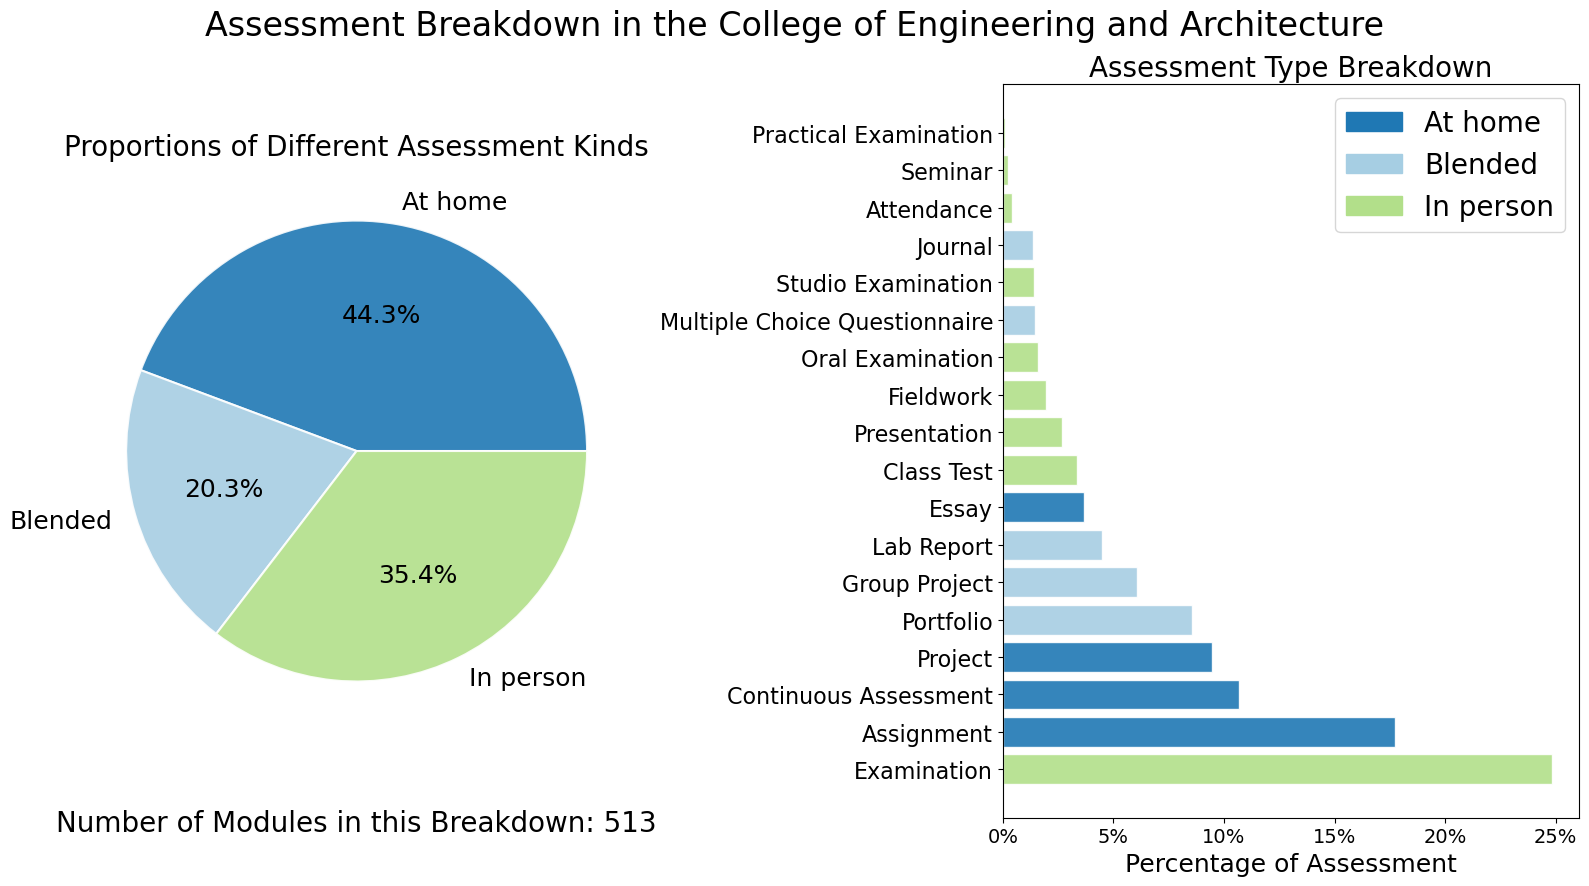

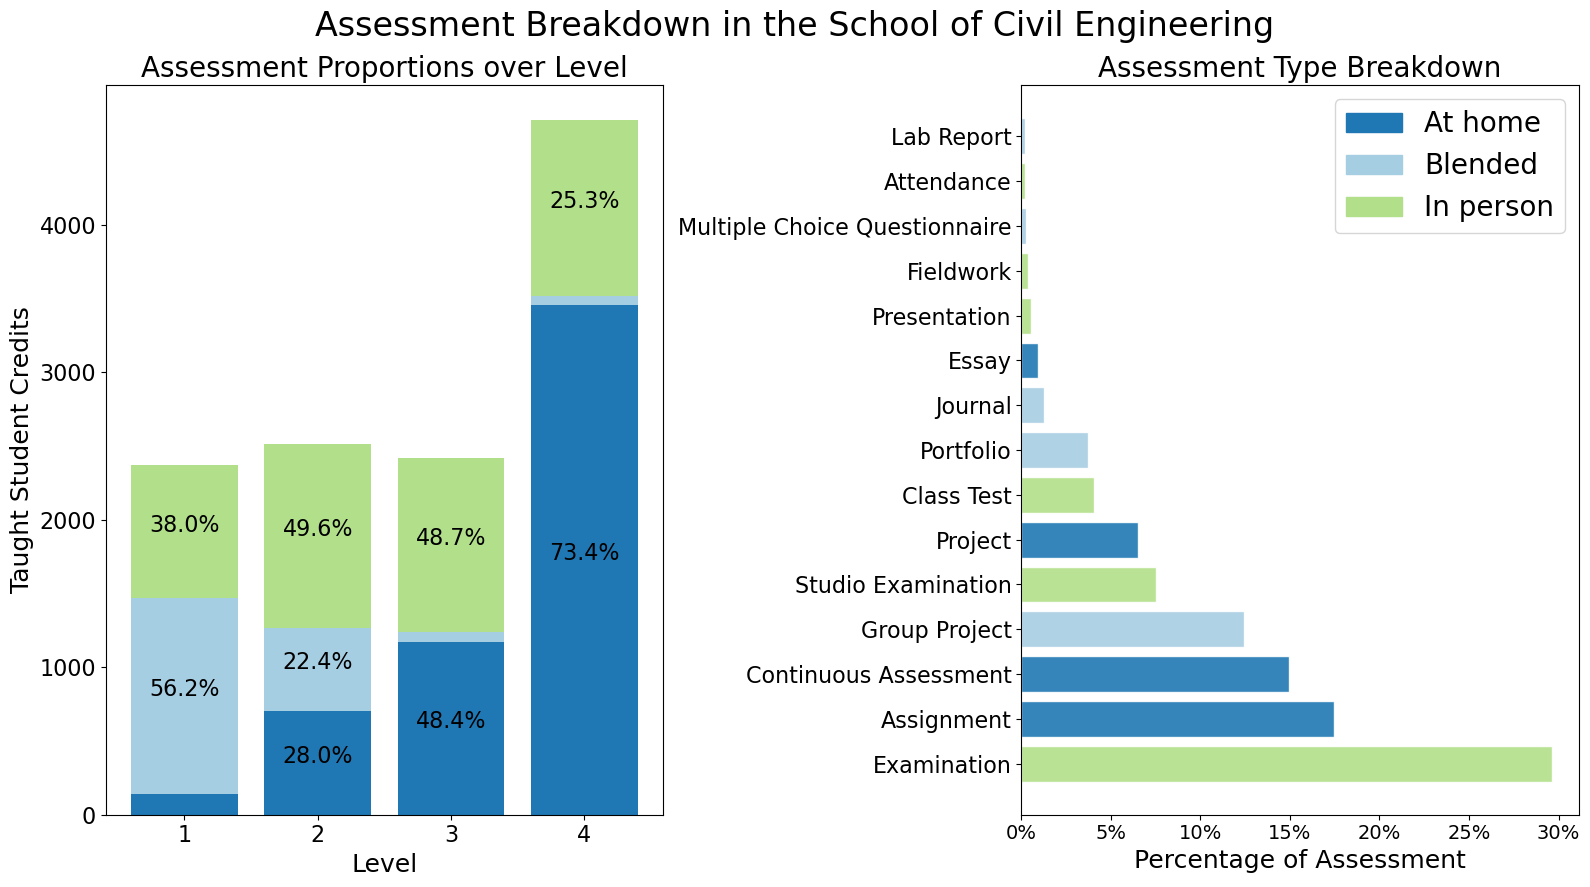

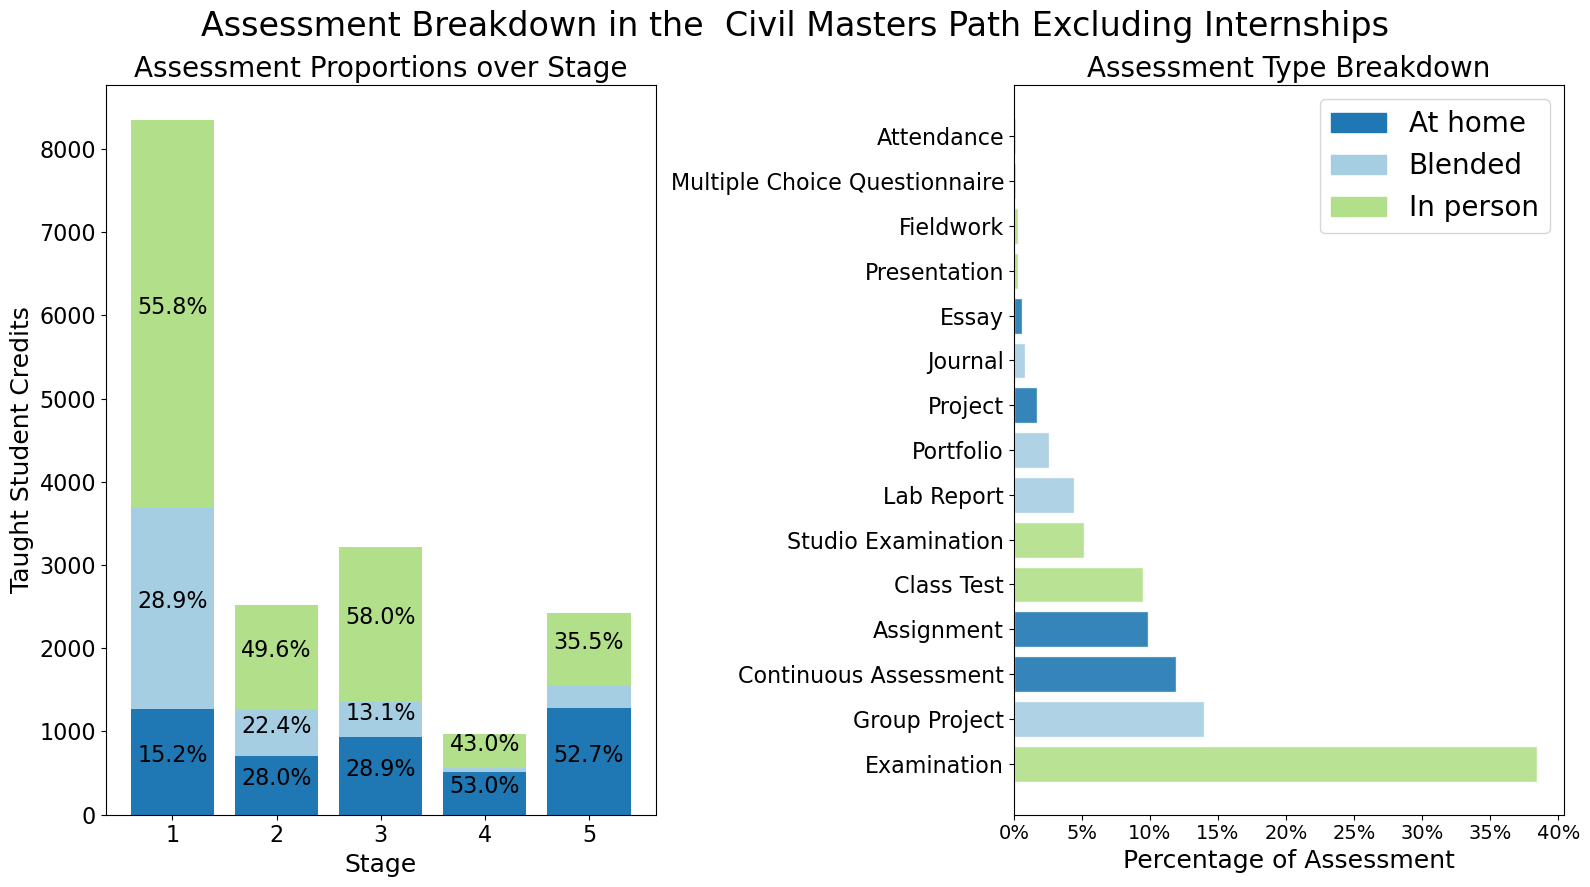

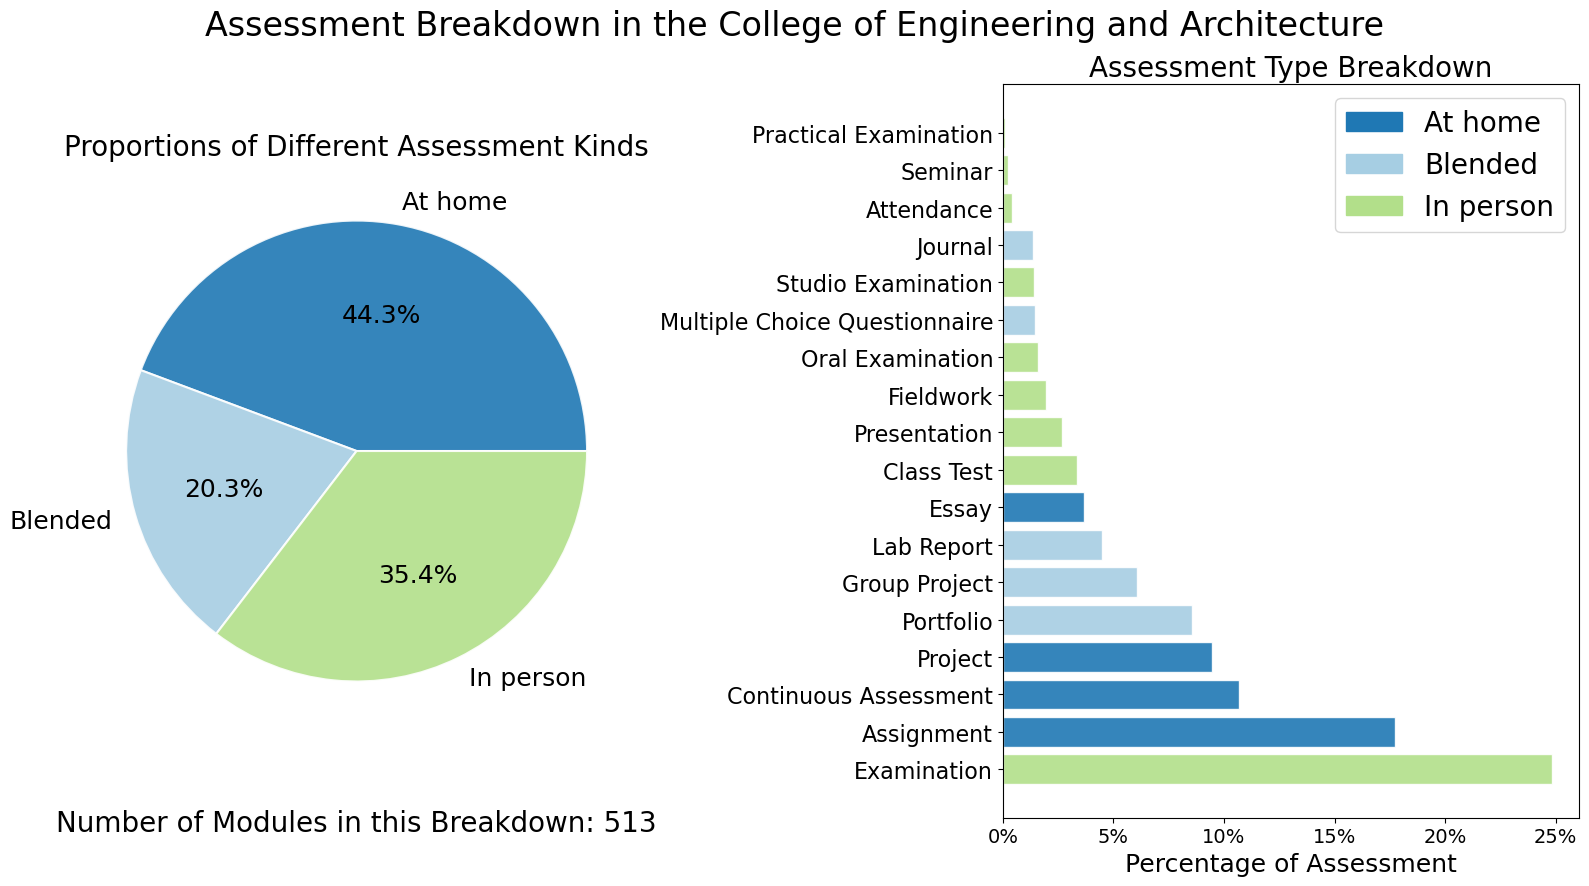

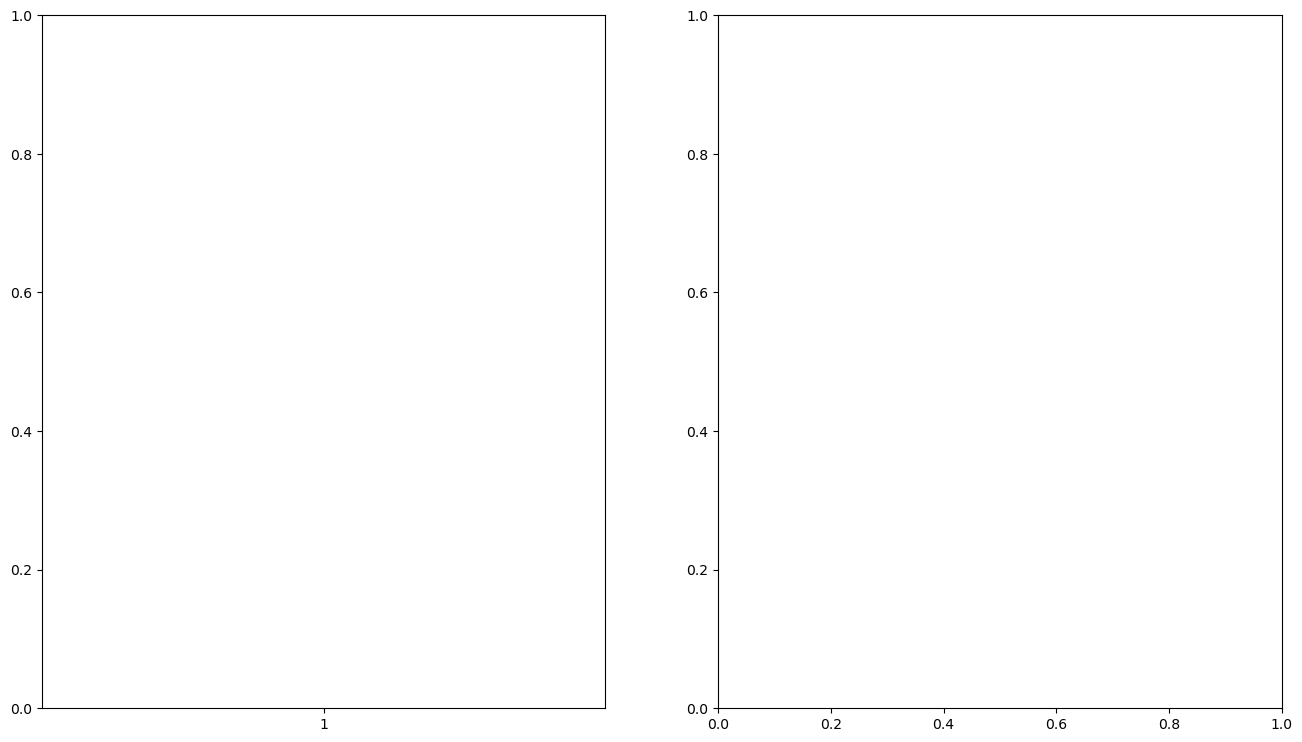

In [12]:
schools=["Civil Engineering", "Mechanical & Materials Eng", "Chem & Bioprocess Engineering", "Biosystems & Food Engineering", \
        "Architecture, Plan & Env Pol", "Electrical & Electronic Eng"]

for school in schools:
    schoolSlideGraphs(school=school)

Reading from ModuleInformation\CivilMastersPath
Reading from ModuleInformation\CivilMastersPath


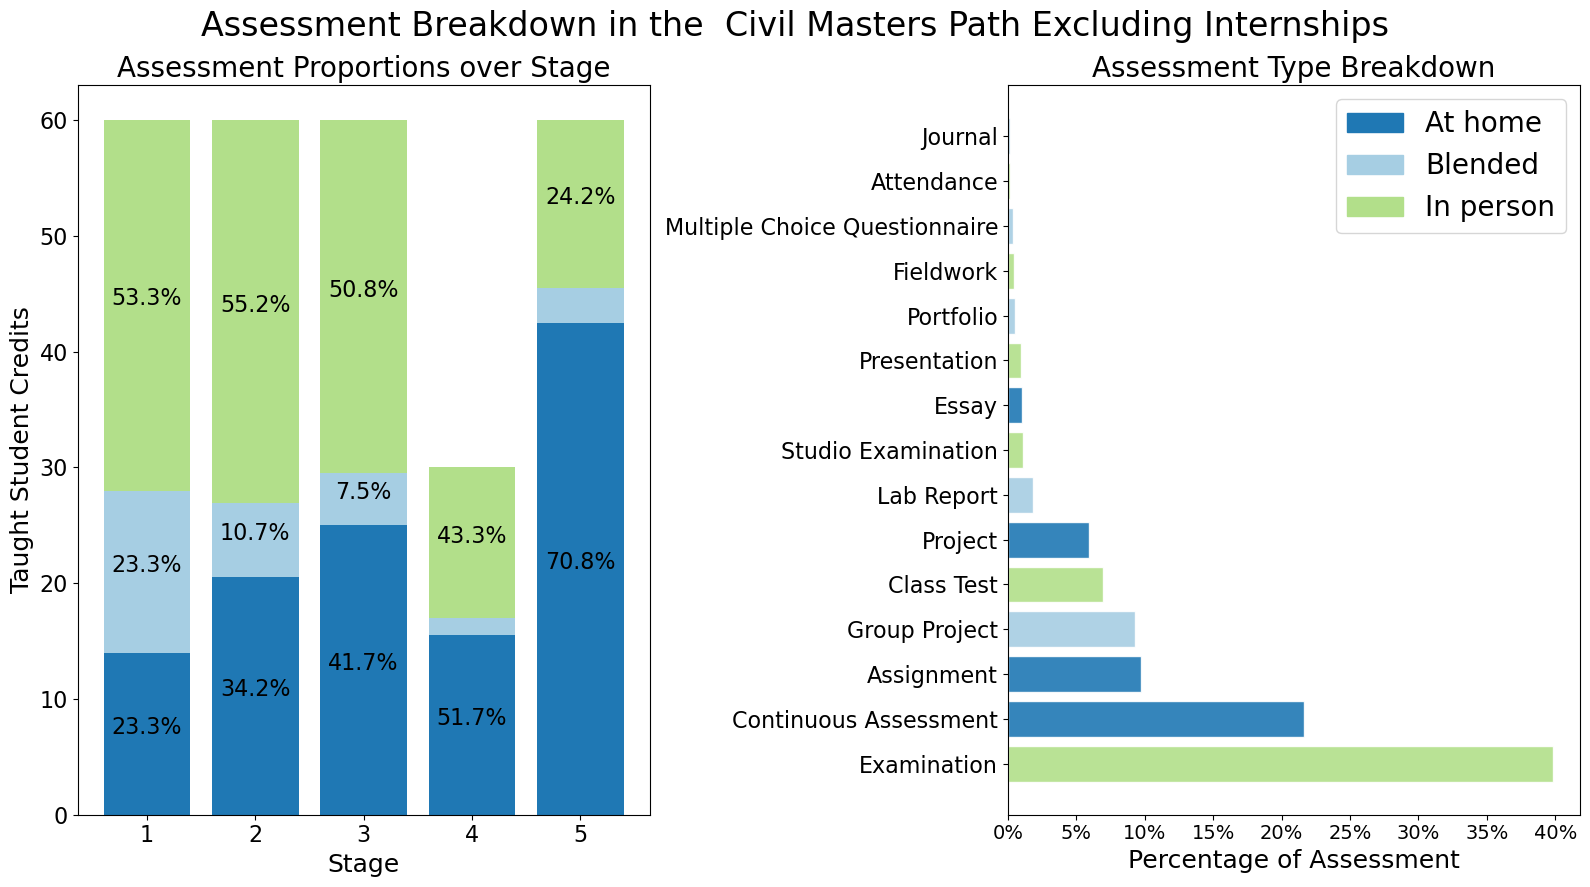

In [13]:
workType_graphs(filename="CivilMastersPath", time=True, with_internships=False)